In [18]:
# export TF_ENABLE_ONEDNN_OPTS=0
# for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2382809161941078759
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 82927812608
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12949293826745047070
physical_device_desc: "device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:0d.0, compute capability: 8.0"
xla_global_id: 416903419
]


2023-12-22 18:19:23.892313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:0d.0, compute capability: 8.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

DATA = r"./data/technical_data_eurusd2.csv"
SAVE = "./models/prob_model.keras"

dataframe = read_csv(DATA, engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [5]:
# cut off first 20 values
dataset = dataset[20:]
dataset = dataset[:, 1:]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back,9))
testX = np.reshape(testX, (testX.shape[0], look_back,9))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 9)))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0)
model.save(SAVE)

18/18 [==============================] - 0s 1ms/step


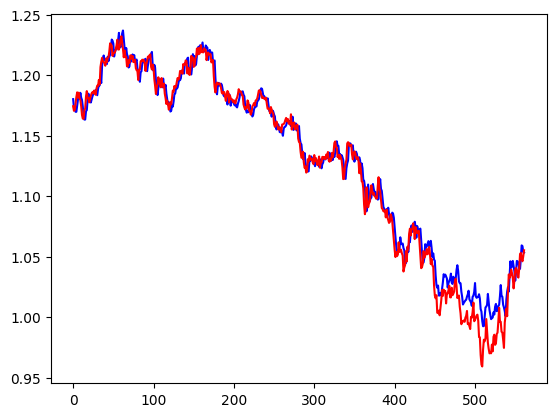

Test Score: 0.010887 RMSE


In [9]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = np.squeeze(trainPredict)
testPredict = np.squeeze(testPredict)

def inverse_transform(arr):
    extended = np.zeros((len(arr), 9))
    extended[:, 0] = arr
    return scaler.inverse_transform(extended)[:, 0]

trainPredict = inverse_transform(trainPredict)
testPredict = inverse_transform(testPredict)
trainY = inverse_transform(trainY)
testY = inverse_transform(testY)

# shift predictions up by one
testPredict = np.delete(testPredict, -1)
testY = np.delete(testY, 0)

plt.plot(testPredict, color="blue")
plt.plot(testY, color="red")
plt.savefig('tmp/technical_data.png')
plt.show()
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.6f RMSE' % (testScore))